In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from experiment_setup import *
from gnn_embedding_functions import UGCN, block_GCN

In [2]:

def mask_split(mask, split_props, seed=0, mode='transductive'):
    np.random.seed(seed)
    
    n, T = mask.shape
    
    if mode == 'transductive':
        # Flatten mask array into one dimension in blocks of nodes per time
        flat_mask = mask.T.reshape(-1)
        n_masks = np.sum(flat_mask)
        
        # Split shuffled flatten mask array indices into correct proportions
        flat_mask_idx = np.where(flat_mask)[0]
        np.random.shuffle(flat_mask_idx)
        split_ns = np.cumsum([round(n_masks * prop) for prop in split_props[:-1]])
        split_idx = np.split(flat_mask_idx, split_ns)
        
    if mode == 'semi-inductive':
        # Find time such that final proportion of masks happen after that time
        T_trunc = np.where(np.cumsum(np.sum(mask, axis=0) / np.sum(mask)) >= 1 - split_props[-1])[0][0]
        
        # Flatten mask arrays into one dimension in blocks of nodes per time
        flat_mask_start = mask[:, :T_trunc].T.reshape(-1)
        flat_mask_end = mask[:, T_trunc:].T.reshape(-1)
        n_masks_start = np.sum(flat_mask_start)
        
        # Split starting shuffled flatten mask array into correct proportions
        flat_mask_start_idx = np.where(flat_mask_start)[0]
        np.random.shuffle(flat_mask_start_idx)
        split_props_start = split_props[:-1] / np.sum(split_props[:-1])
        split_ns = np.cumsum([round(n_masks_start * prop) for prop in split_props_start[:-1]])
        split_idx = np.split(flat_mask_start_idx, split_ns)
    
        # Place finishing flatten mask array at the end
        split_idx.append(n * T_trunc + np.where(flat_mask_end)[0])
    
    split_masks = np.array([[False] * n * T for _ in range(len(split_props))])
    for i in range(len(split_props)):
        split_masks[i, split_idx[i]] = True
        
    return split_masks

In [3]:
# Make the SBM data
n = 300
As, tau, _ = make_iid(n=n, T=2, iid_prob=0.9)
As = [sparse.csr_matrix(A) for A in As]
T = len(As)
node_labels = np.tile(tau, T)


In [4]:
data_mask = np.array([[True] * T for _ in range(n)])

for t in range(T):
    data_mask[np.where(np.sum(As[t], axis=0) == 0)[0], t] = False
    
num_classes = np.unique(node_labels).shape[0]
print(f'Percentage of usable node/time pairs: {100 * np.sum(data_mask) / (n * T) :02.1f}%')

Percentage of usable node/time pairs: 100.0%


In [5]:
props = np.array([0.2, 0.1, 0.35, 0.35])
train_mask, valid_mask, calib_mask, test_mask = mask_split(data_mask, props, mode='transductive')

print(f'Percentage train: {100 * np.sum(train_mask) / np.sum(data_mask) :02.1f}%')
print(f'Percentage valid: {100 * np.sum(valid_mask) / np.sum(data_mask) :02.1f}%')
print(f'Percentage calib: {100 * np.sum(calib_mask) / np.sum(data_mask) :02.1f}%')
print(f'Percentage test:  {100 * np.sum(test_mask)  / np.sum(data_mask) :02.1f}%')

Percentage train: 20.0%
Percentage valid: 10.0%
Percentage calib: 35.0%
Percentage test:  35.0%


In [6]:

# conformal parameters
alpha = 0.1

methods = ["UGCN", "Block GCN"]

print("Running at reduced parameters")
num_epochs = 100


ya_ugcn, model, best_model_acc = UGCN(
    As,
    node_labels,
    model_save_dir="saved_models/sbm_UGCN.pt",
    train_mask=train_mask,
    val_mask=valid_mask,
    test_mask=test_mask,  # Model doesn't train on test, it just prints the accuracy
    num_epochs=num_epochs,
    # epoch_save_dir="saved_epochs/sbm_UGCN",
    return_model=True,
    hidden_channels=32,
)


ya_block, model, best_model_acc = block_GCN(
    As,
    node_labels,
    model_save_dir="saved_models/sbm_block_GCN.pt",
    train_mask=train_mask,
    val_mask=valid_mask,
    test_mask=test_mask,  # Model doesn't train on test, it just prints the accuracy
    num_epochs=num_epochs,
    # epoch_save_dir="saved_epochs/sbm_block_GCN",
    return_model=True,
    hidden_channels=32,
)



Running at reduced parameters
Using a single identity for unfolded attributes
Training Unfolded GCN...


 10%|█         | 10/100 [00:01<00:12,  7.23it/s]

Epoch: 010, Loss: 0.6877, Val: 0.4500, Test: 0.4810


 21%|██        | 21/100 [00:02<00:10,  7.45it/s]

Epoch: 020, Loss: 0.6833, Val: 0.4500, Test: 0.4810


 31%|███       | 31/100 [00:04<00:10,  6.45it/s]

Epoch: 030, Loss: 0.6811, Val: 0.4500, Test: 0.4810


 41%|████      | 41/100 [00:05<00:07,  7.69it/s]

Epoch: 040, Loss: 0.6798, Val: 0.4500, Test: 0.4810


 51%|█████     | 51/100 [00:07<00:07,  6.59it/s]

Epoch: 050, Loss: 0.6789, Val: 0.4500, Test: 0.4810


 60%|██████    | 60/100 [00:08<00:05,  7.96it/s]

Epoch: 060, Loss: 0.6772, Val: 0.4500, Test: 0.4810


 71%|███████   | 71/100 [00:09<00:03,  9.50it/s]

Epoch: 070, Loss: 0.6754, Val: 0.4500, Test: 0.4810


 81%|████████  | 81/100 [00:10<00:02,  8.19it/s]

Epoch: 080, Loss: 0.6724, Val: 0.4500, Test: 0.4810


 91%|█████████ | 91/100 [00:12<00:01,  7.93it/s]

Epoch: 090, Loss: 0.6705, Val: 0.4500, Test: 0.4810


100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


Epoch: 100, Loss: 0.6688, Val: 0.4500, Test: 0.4810
Training finished.
Best model accuracy: 0.48095238095238096
Using a single identity for block attributes
Training Block GCN...


 12%|█▏        | 12/100 [00:00<00:05, 15.78it/s]

Epoch: 010, Loss: 0.6897, Val: 0.4500, Test: 0.4810


 22%|██▏       | 22/100 [00:01<00:05, 15.15it/s]

Epoch: 020, Loss: 0.6864, Val: 0.4500, Test: 0.4810


 32%|███▏      | 32/100 [00:02<00:04, 14.48it/s]

Epoch: 030, Loss: 0.6846, Val: 0.4500, Test: 0.4810


 42%|████▏     | 42/100 [00:02<00:03, 16.26it/s]

Epoch: 040, Loss: 0.6826, Val: 0.4500, Test: 0.4810


 52%|█████▏    | 52/100 [00:03<00:03, 15.41it/s]

Epoch: 050, Loss: 0.6811, Val: 0.4500, Test: 0.4810


 62%|██████▏   | 62/100 [00:04<00:02, 14.95it/s]

Epoch: 060, Loss: 0.6810, Val: 0.4500, Test: 0.4810


 72%|███████▏  | 72/100 [00:04<00:01, 15.45it/s]

Epoch: 070, Loss: 0.6795, Val: 0.4500, Test: 0.4810


 82%|████████▏ | 82/100 [00:05<00:01, 14.51it/s]

Epoch: 080, Loss: 0.6786, Val: 0.4500, Test: 0.4810


 92%|█████████▏| 92/100 [00:06<00:00, 15.40it/s]

Epoch: 090, Loss: 0.6768, Val: 0.4500, Test: 0.4810


100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


Epoch: 100, Loss: 0.6760, Val: 0.4500, Test: 0.4810
Training finished.
Best model accuracy: 0.5380952380952381


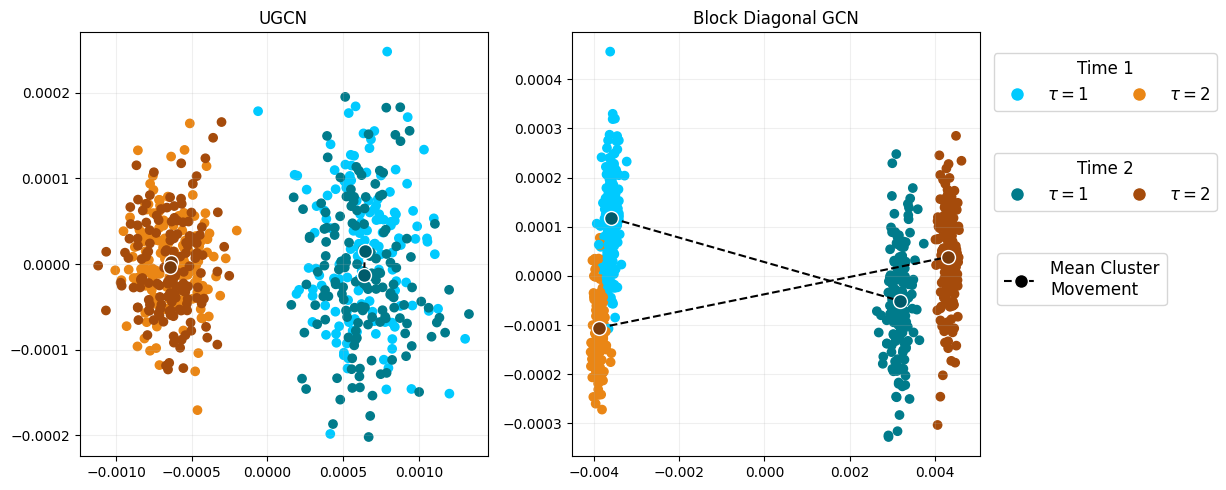

In [7]:
from matplotlib.lines import Line2D


# Visualise the drift in the naive GNN embedding

light_tau_colours = {0: "#00CAFF", 1: "#EA8615"}
dark_tau_colours = {0: "#007B8B", 1: "#A54B0B"}
darker_tau_colours = {0: "#005B6B", 1: "#7A3B0B"}

from sklearn.decomposition import PCA

ya_ugcn_pca = PCA(n_components=2).fit_transform(ya_ugcn)
ya_block_pca = PCA(n_components=2).fit_transform(ya_block)

embeddings_by_method = [ya_ugcn_pca, ya_block_pca]
methods = ["UGCN", "Block Diagonal GCN"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, embeddings in enumerate(embeddings_by_method):
    axs[i].grid(alpha=0.2)
    axs[i].scatter(
        embeddings[0:n, 0], embeddings[0:n, 1], c=[light_tau_colours[t] for t in tau]
    )
    axs[i].scatter(
        embeddings[n : 2 * n, 0],
        embeddings[n : 2 * n, 1],
        c=[dark_tau_colours[t] for t in tau],
    )

    axs[i].set_title(f"{methods[i]}")

    # Get observed value of the test
    for j in range(2):
        mean_x_1 = np.mean(embeddings[0:n, 0][tau == j])
        mean_y_1 = np.mean(embeddings[0:n, 1][tau == j])
        mean_x_2 = np.mean(embeddings[n : 2 * n, 0][tau == j])
        mean_y_2 = np.mean(embeddings[n : 2 * n, 1][tau == j])

        axs[i].plot(
            [mean_x_1, mean_x_2],
            [mean_y_1, mean_y_2],
            # c="black",
            marker="o",
            # set line colour to black
            c="black",
            mfc=darker_tau_colours[j],
            linestyle="--",
            markersize=10,
            mec="white",
        )


node_elements_1 = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=1$",
        markerfacecolor=light_tau_colours[0],
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=2$",
        markerfacecolor=light_tau_colours[1],
        markersize=10,
    ),
]
node_elements_2 = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=1$",
        markerfacecolor=dark_tau_colours[0],
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=2$",
        markerfacecolor=dark_tau_colours[1],
        markersize=10,
    ),
]

fig.legend(
    handles=node_elements_1,
    loc="upper right",
    bbox_to_anchor=(1.23, 0.9),  # Adjust these values to move the legend
    title="Time 1",
    ncol=2,
    title_fontsize="large",
    fontsize="large",
)
fig.legend(
    handles=node_elements_2,
    loc="upper right",
    bbox_to_anchor=(1.23, 0.7),  # Adjust these values to move the legend
    title="Time 2",
    ncol=2,
    title_fontsize="large",
    fontsize="large",
)

line_elements = [
    Line2D(
        [0, 1],
        [0, 1],
        c="black",
        marker="o",
        linestyle="--",
        label="Mean Cluster\nMovement",
        mec="white",
        markersize=10,
    ),
]
fig.legend(
    handles=line_elements,
    loc="upper right",
    bbox_to_anchor=(1.18, 0.5),  # Adjust these values to move the legend
    # title="Mean node embedding",
    title_fontsize="large",
    fontsize="large",
)

plt.tight_layout()


